<h1>Data mining </h1>
<h3>Home Assignment 2 - Group 5</h3>

<h4>Marcel Buczkowski 59426 <br>
Emanuele Tartaglione 61294 <br>
Alberto Fallocco 59378</h4> 

<h5>Time spent - 3,5 hours each </h5>

As a first step we read the files and prepared the dataframes with products and transactions.

In [1]:
#read files
lines=open("products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname                                       
    
#read transactions
import pickle
orders=pickle.load(open("order_products.pickle", "rb"))

#check products on order 2:
print(f"Order's two products:")
for prod in orders[2]: print(products[prod])                     

orders_list = list(orders.values())

Order's two products:
Organic Egg Whites
Michigan Organic Kale
Garlic Powder
Coconut Butter
Natural Sweetener
Carrots
Original Unflavored Gelatine Mix
All Natural No Stir Creamy Almond Butter
Classic Blend Cole Slaw


We then prepared a binary dataframe storing boolean values (showing whether or not each transaction contains each product), in order to be able to run the Apriori and FP-growth algorithms.

In [2]:
#prepare binary_database
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(orders_list).transform(orders_list, sparse=True)
binary_database = pd.DataFrame.sparse.from_spmatrix(trans_array, columns=tr_enc.columns_)
#change columns so that their indexes begin with 0 - needs to be changed back at the end when replacing ids of productst to actual names
binary_database.columns = [x - 1 for x in binary_database.columns]   
binary_database.iloc[:4, :]

,0,1,2,3,4,5,6,7,8,9,...,49678,49679,49680,49681,49682,49683,49684,49685,49686,49687
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As the next step we evaluated performance of different algorithms for generating itemsets and plotting the results: as a result of this we were able to choose one of them for further analysis.

In [3]:
from mlxtend.frequent_patterns import apriori 
from mlxtend.frequent_patterns import fpgrowth     
from pyfim import pyeclat             
from PD_freqitems import freqitemsets                 
import time

D={"threshold": [0.1, 0.05, 0.02, 0.015, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori= apriori(binary_database, min_support = min_supp, use_colnames=True)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg=fpgrowth(binary_database, min_support = min_supp, use_colnames=True)     
    t2 = time.time()
    D["FP-growth"].append(t2-t1)
  
    FI_eclat= pyeclat(orders_list, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_freqitems= freqitemsets(orders_list, min_supp)
    t4 = time.time()
    D["PD"].append(t4-t3)

In [4]:
df_performance=pd.DataFrame(D)
df_performance

,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.100,2,3.394817,10.656724,45.945542,26.071187
1,0.050,6,1.492277,11.405893,45.625491,23.135855
2,0.020,39,14.398678,17.450588,51.688697,30.053122
3,0.015,69,105.450442,28.193062,59.529975,34.884676
4,0.010,116,646.019305,39.838769,62.593263,50.723650


The table above displays summary metrics from the itemsets mining, with regard to the approach implemented. A primary takeaway from it is that Apriori is very fast - and works best, comparatively - for higher thresholds, although it seems to require a significant amount of time for lower ones - performing the worst among all models tested. FP-growth takes longer than Apriori for higher thresholds, but comes out better for lower ones. Moreover, FP-growth displays fairly similar time spans for the first three thresholds tested, then experiences a sensible time increase for the 0.015 threshold. Interestingly, ECLAT and PD feature smaller influence of the threshold on time execution - especially ECLAT.  
We plotted the results below for more visually pleasing analysis.

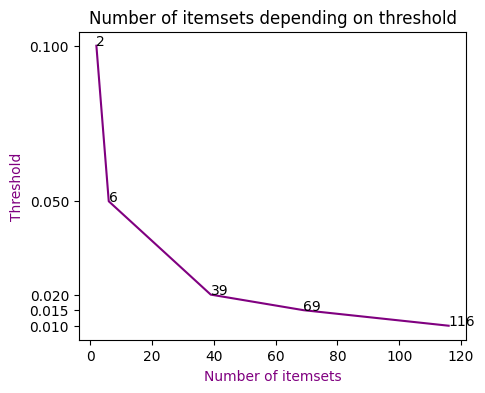

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.plot(D['num_itemsets'], D['threshold'], color = 'purple');plt.yticks(D['threshold']);plt.xlabel('Number of itemsets', color = 'purple');plt.ylabel('Threshold', color = 'purple')
plt.title('Number of itemsets depending on threshold')
for index in range(len(D['num_itemsets'])):
  plt.text(D['num_itemsets'][index], D['threshold'][index], D['num_itemsets'][index], size=10)
plt.show()

The plot above shows the effects of threshold tuning on the number of itemsets found the algorithm is able to find, which is stable across all models tested. As the graph displays, the highest threshold (0.1) - which is relatively low as a support value - only results in 2 itemsets found, whereas a more satisfying value of 102 is produced by the lowest threshold tested (0.01).

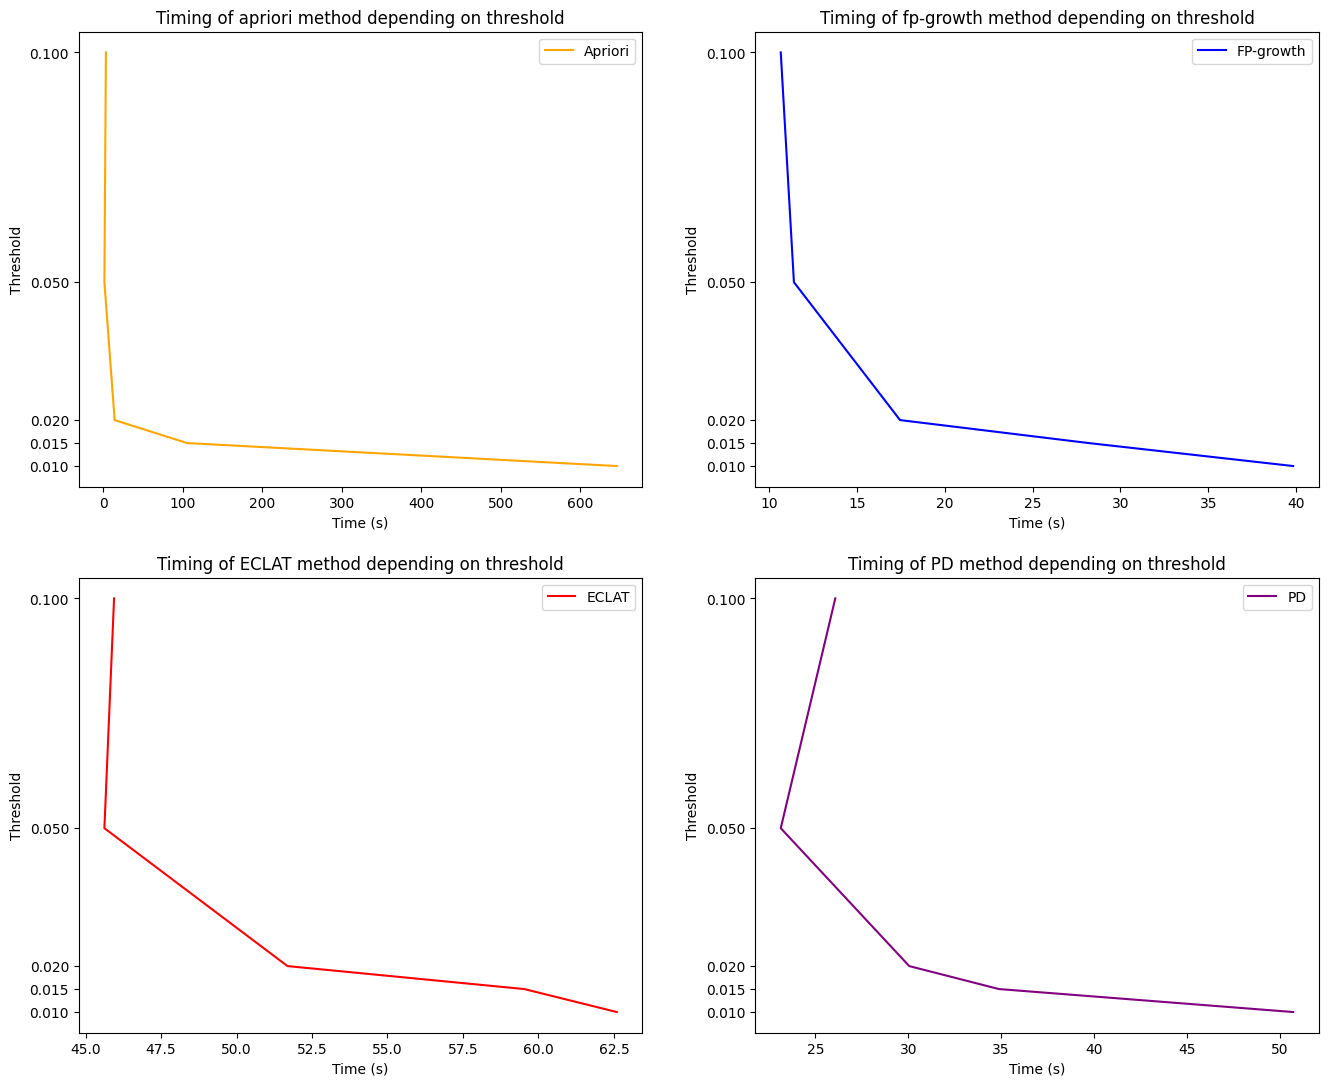

In [6]:
plt.figure(figsize=(16,13))
plt.subplot(2, 2, 1)
plt.plot(D["apriori"], D['threshold'], color = 'orange',  label ='Apriori');plt.yticks(D['threshold']);plt.xlabel('Time (s)');plt.ylabel('Threshold');plt.title('Timing of apriori method depending on threshold');plt.legend()
plt.subplot(2, 2, 2)
plt.plot(D["FP-growth"], D['threshold'], color = 'blue',  label ='FP-growth');plt.yticks(D['threshold']);plt.legend();plt.xlabel('Time (s)');plt.ylabel('Threshold');plt.title('Timing of fp-growth method depending on threshold')
plt.subplot(2, 2, 3)
plt.plot(D["ECLAT"], D['threshold'], color = 'red',  label ='ECLAT');plt.yticks(D['threshold']);plt.legend();plt.xlabel('Time (s)');plt.ylabel('Threshold');plt.title('Timing of ECLAT method depending on threshold')
plt.subplot(2, 2, 4)
plt.plot(D["PD"], D['threshold'], color = 'purple',  label ='PD');plt.yticks(D['threshold']);plt.legend();plt.xlabel('Time (s)');plt.ylabel('Threshold');plt.title('Timing of PD method depending on threshold')
plt.show()

Plots above show time needed for each method to calculate frequent itemset depending on thresholds. As mentioned before, thresholds have a significant impact time-wise for Apriori, as it can take long for small thresholds. FP-growth performance follows a similar shape, with shorter times overall. The plot for ECLAT seems to suggest - to some extent - that threshold does not really influence time. Lastly, PD shows good performances comparatively to other methods; as opposed to ECLAT, threshold definitely appears to influence time needed for the algorithm to run.   
We created a log-log plot of the four graphs for comparing and contrasting.

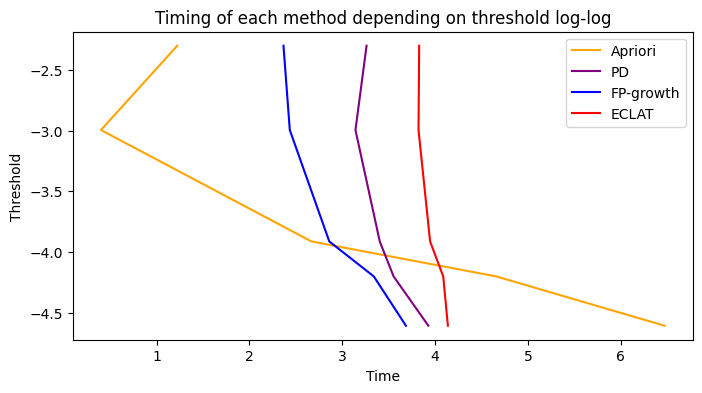

In [7]:
plt.figure(figsize=(8,4))
plt.plot(np.log(D["apriori"]), np.log(D['threshold']), color = 'orange',  label ='Apriori')
plt.plot(np.log(D["PD"]), np.log(D['threshold']), color = 'purple',  label ='PD')
plt.plot(np.log(D["FP-growth"]), np.log(D['threshold']), color = 'blue',  label ='FP-growth')
plt.plot(np.log(D["ECLAT"]), np.log(D['threshold']), color = 'red',  label ='ECLAT')
plt.xlabel('Time');plt.ylabel('Threshold');plt.title('Timing of each method depending on threshold log-log');plt.legend()
plt.show()

Since Apriori seems to have the worst performance out of all the methods, we we were left with PD, FP-growth and ECLAT to choose from.  
They seem to be similar efficiency-wise, but FP-growth proved to be faster than ECLAT, and despite it being slightly slower than PD it is, on the other hand, better tested, known and estabilished. For these reasons, we decided stick with FP-growth algorithm for further analysis.  
As we wanted to take a closer look to the model we selected before generating the rules, we tested it again adding more thresholds.


In [25]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.015, 0.01, 0.005], 
   "num_itemsets":[], 
   "FP":[], 
}
for min_supp in D["threshold"]:
    t0 = time.time()
    FI_fpg=fpgrowth(binary_database, min_support = min_supp, use_colnames=True) 
    t1 = time.time()
    D["num_itemsets"].append(FI_fpg.shape[0])
    D["FP"].append(t1-t0)
    print(min_supp, FI_fpg.shape[0],"\n\tFP-growth time:",t1-t0)


0.2 0 
	FP-growth time: 9.690454483032227
0.1 2 
	FP-growth time: 10.335190773010254
0.05 6 
	FP-growth time: 11.330554485321045
0.02 39 
	FP-growth time: 17.408429384231567
0.015 69 
	FP-growth time: 23.62503480911255
0.01 116 
	FP-growth time: 34.101354122161865
0.005 326 
	FP-growth time: 58.28295373916626


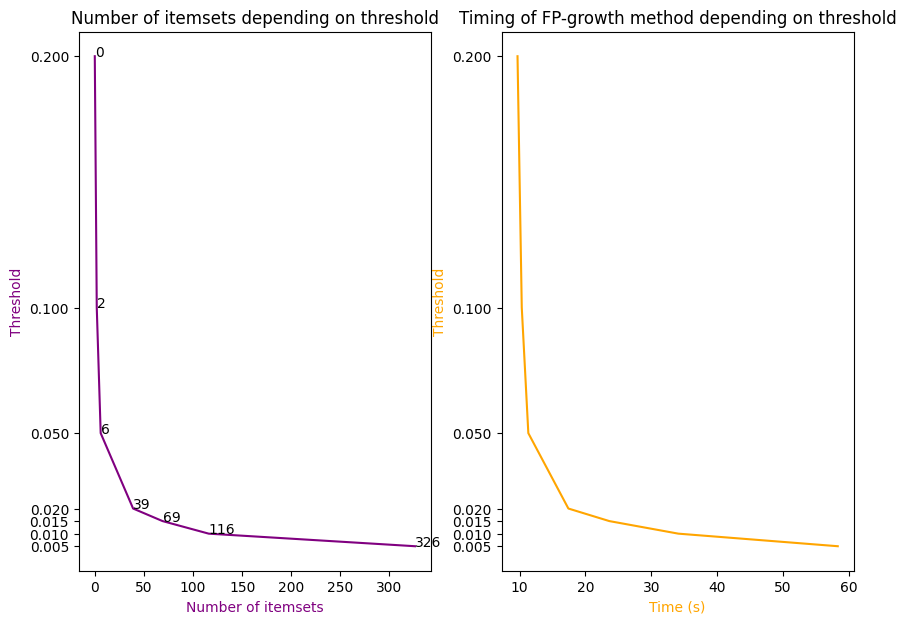

In [30]:
plt.figure(figsize=(10,7))
plt.subplot(1, 2, 1)
plt.plot(D['num_itemsets'], D['threshold'], color = 'purple');plt.yticks(D['threshold']);plt.xlabel('Number of itemsets', color = 'purple');plt.ylabel('Threshold', color = 'purple');plt.title('Number of itemsets depending on threshold')
for index in range(len(D['num_itemsets'])):
  plt.text(D['num_itemsets'][index], D['threshold'][index], D['num_itemsets'][index], size=10)
plt.subplot(1, 2, 2);plt.plot(D["FP"], D['threshold'], color = 'orange');plt.yticks(D['threshold']);plt.xlabel('Time (s)', color = 'orange');plt.ylabel('Threshold', color = 'orange');plt.title('Timing of FP-growth method depending on threshold')
plt.show()

Despite a 0.010 support seeming fairly low, and 116 itemsets deemed enough for later analysis, we decided to opt for a support of 0.005 in order to generate more itemsets and filter out the most important ones with other measures in the next stage. Therefore, we generated the itemsets that are shown below.

In [8]:
FI_fpg=fpgrowth(binary_database, min_support = 0.005, use_colnames=True) 
FI_fpg['length'] = FI_fpg['itemsets'].apply(lambda x: len(x))
print(FI_fpg.head())
print(f"Number of sets: {FI_fpg.shape[0]}. Maximal size of sets: {max(FI_fpg['length'])}")

    support itemsets  length
0  0.022625  (17793)       1
1  0.020980  (28984)       1
2  0.006034  (33119)       1
3  0.075251  (21902)       1
4  0.016202  (46666)       1
Number of sets: 326. Maximal size of sets: 2


We then generated the actual rules, which are visualized below.

In [13]:
from mlxtend.frequent_patterns import association_rules

all_rules = association_rules(FI_fpg, metric="confidence", min_threshold=0.2)
all_rules['antecedents'] = all_rules['antecedents'].apply(lambda x: products[next(iter(x))+1])
all_rules['consequents'] = all_rules['consequents'].apply(lambda x: products[next(iter(x))+1])
print("Number of Rules:", len(all_rules))
all_rules.sort_values(by=['confidence'], ascending=False)

Number of Rules: 37


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
17,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923
11,Honeycrisp Apple,Banana,0.024812,0.146993,0.008836,0.356128,2.422752,0.005189,1.324809
16,Cucumber Kirby,Banana,0.030270,0.146993,0.009984,0.329826,2.243815,0.005534,1.272813
31,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023380,0.118030,0.007267,0.310836,2.633546,0.004508,1.279769
7,Organic Avocado,Banana,0.054999,0.146993,0.016609,0.301982,2.054395,0.008524,1.222042
15,Seedless Red Grapes,Banana,0.025721,0.146993,0.007650,0.297428,2.023410,0.003869,1.214119
3,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944
2,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511
30,Blueberries,Banana,0.017402,0.146993,0.005066,0.291102,1.980377,0.002508,1.203286
8,Yellow Onions,Banana,0.022759,0.146993,0.006584,0.289311,1.968190,0.003239,1.200253


A total number of 37 rules were detected, - 5 of which are shown above - using a minimum confidence threshold of 0.2, which means that 20% of consumers that buy product X will also buy product Y. All rules featured either fruits or vegetables, and bananas stood out as the most common product.  
Such an output seemed reasonable to us in light of the widespread tendency of buying all fruit and vegetable supplies in one trip to the store, as opposed to buying single pieces fruits or vegetables. We did not manage to detect correlations between other products of different kind.  
However, we still decided to filter the most important rules by using other metrics that we measured while generating rules.



In [14]:
best_rules = all_rules[(all_rules['lift'] >= 2.2) & (all_rules['conviction'] >= 1.2)]
print("Number of Best Rules:", len(best_rules))
best_rules

Number of Best Rules: 13


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511
3,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944
4,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801
9,Organic Cilantro,Limes,0.021626,0.043743,0.005464,0.252647,5.775753,0.004518,1.279525
11,Honeycrisp Apple,Banana,0.024812,0.146993,0.008836,0.356128,2.422752,0.005189,1.324809
16,Cucumber Kirby,Banana,0.030270,0.146993,0.009984,0.329826,2.243815,0.005534,1.272813
17,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923
19,Organic Blueberries,Organic Strawberries,0.031124,0.082331,0.007389,0.237418,2.883704,0.004827,1.203371
21,Organic Lemon,Organic Hass Avocado,0.027294,0.066436,0.006609,0.242131,3.644560,0.004795,1.231827
26,Organic Cucumber,Bag of Organic Bananas,0.025006,0.118030,0.006698,0.267862,2.269453,0.003747,1.204651


Firstly we focused on lift since it does not take into account the popularity of item Y, as opposed to confidence which describes the likelihood of purchasing item Y when item X is chosen. We increased minimum lift to 2.2, which means that buying product A increases chances of buying product B of 2.2 times. In doing so, we reduced the influence of bananas - which we deemed useful for avoiding distortions in our results - as bananas usually stand as an overall frequently purchased product, thus purchased together with a wide spectrum of different items. Moreover, we closely examined conviction, which again compares the probability that product X is present when product Y is not. As we know conviction should be as high as possible and never equal to 1,we set a parameter minimum of 1.2.  
As a result, we came up with 13 rules, 5 of which are shown above.


As for the next stage of the analysis - creating closed and maximal itemsets - we sadly experienced memory deficiency issues while trying to implement the FP-max method. Therefore, we used the ECLAT algorithm for this part of analysis.

In [9]:
itemsets_closed = pyeclat(orders_list, 0.005, target="c")    
print("Number of Closed Itemsets:", len(itemsets_closed))
itemsets_closed.head(4)

Number of Closed Itemsets: 326


,support,itemsets
0,0.005017,"(26790,)"
1,0.005025,"(5818,)"
2,0.005053,"(17872,)"
3,0.005076,"(21267,)"


In [10]:
itemsets_maximal = pyeclat(orders_list, 0.005, target="m")    
print("Number of Maximal Itemsets", len(itemsets_maximal))
itemsets_maximal.head(4)

Number of Maximal Itemsets 296


,support,itemsets
0,0.005017,"(26790,)"
1,0.005025,"(5818,)"
2,0.005053,"(17872,)"
3,0.005076,"(21267,)"


As it is shown in the table above, the number of closed itemsets is equal to number of all itemsets detected before, indicating that the very first detection of itemsets already resulted in finding only closed itemsets. These results would be most likely different if we would reduce minimum support threshold; however, as we thought it being already significantly low we focused on maximal itemsets - whose count was indeed smaller - and we were able to cut the total number of 326 itemsets down to 296 maximal items.

The last step was to generate most important rules for maximal itemsets:

In [12]:
from mlxtend.frequent_patterns import association_rules
all_rules = association_rules(itemsets_maximal, metric="confidence", min_threshold=0.01, support_only=True)
all_rules['antecedents'] = all_rules['antecedents'].apply(lambda x: products[next(iter(x))+1])
all_rules['consequents'] = all_rules['consequents'].apply(lambda x: products[next(iter(x))+1])
print("Number of Rules:", len(all_rules))
all_rules.sort_values(by=['confidence'], ascending=False).head(5)

Number of Rules: 28


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Golden Toasted Bread Crumbs,Shredded 3 Cheese Italian,NaN,NaN,0.010558,NaN,NaN,NaN,NaN
1,Shredded 3 Cheese Italian,Golden Toasted Bread Crumbs,NaN,NaN,0.010558,NaN,NaN,NaN,NaN
2,Fat Free Low Sodium Poppyseed Dressing,Egg Pasta Fettuccine,NaN,NaN,0.010533,NaN,NaN,NaN,NaN
3,Egg Pasta Fettuccine,Fat Free Low Sodium Poppyseed Dressing,NaN,NaN,0.010533,NaN,NaN,NaN,NaN
4,Warrior Blend Vanilla Dietary Supplement,Egg Pasta Fettuccine,NaN,NaN,0.012599,NaN,NaN,NaN,NaN


We tried to do the last point, but unfortunately the best we could do is to generate the rules for the maximal itemsets with the support metric only.